## 01 - EDA

In [4]:
import os, json, hashlib, random, shutil, time, zipfile, re, math
from collections import defaultdict, Counter
from datetime import datetime
import cv2, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

from PIL import Image as PILImage
from IPython.display import display, Image as DisplayImage, Markdown

pd.set_option('display.max_rows', None)  #	يخلي الجداول (DataFrame) تطلع كاملة في النوتبوك وما 

In [5]:
DATA_PATH = "/Users/amirah/Ghiras's datast/THE DATA"

# Make OUTPUT_DIR absolute so saved files are easy to find
OUTPUT_DIR = (Path().resolve() / "EDA_outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)   #يعمل إنشاء للمجلد و ما يعطي خطأ لو المجلد موجود اصلا 

IMG_EXTS = [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"]

# Random seed for reproducibility (sampling)
RANDOM_SEED = 42   
random.seed(RANDOM_SEED)   #نضمن إن النتائج تبقى نفسها كل مرة نشغل الكود

# Limit how many images to scan per class for expensive checks (None => all)
SIZE_STATS_LIMIT_PER_CLASS = None  
DUP_SCAN_LIMIT_PER_CLASS   = None  

# Toggle optional visuals
ENABLE_PIE_CHART   = True  #رسم Pie Chart لتوزيع الصور حسب الفئات
ENABLE_SAMPLE_GRID = True  #يعرض Grid (شبكة) فيها عينات من الصور
ENABLE_DUP_CHECK   = True  #يفعل فحص التكرارات

داله تعرض الروسومات هنا و تنحفظ في ملف خارجي عشان نوصل لها بسرعه

In [6]:
def is_image(p: Path) -> bool:
    return p.suffix.lower() in IMG_EXTS

def safe_imread(path: Path, flags=cv2.IMREAD_UNCHANGED):
    try:
        return cv2.imread(str(path), flags)
    except Exception:
        return None

def md5_of_file(path: Path, chunk_size=1 << 20):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            h.update(chunk)
    return h.hexdigest()

# show & save plots
def savefig_and_show(path, dpi=200):
    plt.tight_layout()
    plt.savefig(path, dpi=dpi)
    plt.show()
    plt.close()

def show_png_file(path):
    display(Image(filename=str(path)))
    
def is_image(p: Path) -> bool:
    return p.suffix.lower() in IMG_EXTS

def safe_imread(path: Path, flags=cv2.IMREAD_UNCHANGED):
    try:
        return cv2.imread(str(path), flags)
    except Exception:
        return None

def md5_of_file(path: Path, chunk_size=1 << 20):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            h.update(chunk)
    return h.hexdigest()

# show & save plots
def savefig_and_show(path, dpi=200):
    plt.tight_layout()
    plt.savefig(path, dpi=dpi)
    plt.show()
    plt.close()

def show_png_file(path):
    display(Image(filename=str(path)))

Report logger 

In [7]:
REPORT_PATH = OUTPUT_DIR / "eda_report.md"  #هذا الملف يجمع كل النصوص + الجداول + الصور اللي نطلعها

def report_start(title="plant diseases EDA Report"):    #ينشئ ملف التقرير ويكتب فيه العنوان الرئيسي
    REPORT_PATH.write_text(f"# {title}\n\n", encoding="utf-8")  #يبدأ تقرير جديد كل مرة

def report_section(title, text=None):  #يضيف عنوان فرعي 
    with REPORT_PATH.open("a", encoding="utf-8") as f:
        f.write(f"\n\n## {title}\n\n")
        if text:
            f.write(text + "\n")

def _csv_preview_block(df, rows):
    # embed first rows as a code block CSV (avoids tabulate dependency)
    preview = df.head(rows).to_csv(index=False)
    return f"\n**Preview ({min(rows, len(df))} rows)**:\n\n```\n{preview}\n```\n"

def report_table(caption, df: pd.DataFrame, csv_name: str, show_rows=None):
    csv_path = OUTPUT_DIR / csv_name
    df.to_csv(csv_path, index=False)
    if show_rows is None:
        show_rows = len(df)
    with REPORT_PATH.open("a", encoding="utf-8") as f:
        f.write(f"\n**{caption}** — saved CSV: `{csv_path.name}`\n")
        f.write(_csv_preview_block(df, show_rows))

def report_image(caption, img_path):
    rel = img_path.relative_to(OUTPUT_DIR)
    with REPORT_PATH.open("a", encoding="utf-8") as f:
        f.write(f"\n**{caption}**\n\n![{caption}]({rel.as_posix()})\n")

def report_kv(title, d: dict):
    with REPORT_PATH.open("a", encoding="utf-8") as f:
        f.write(f"\n\n## {title}\n\n")
        for k,v in d.items():
            f.write(f"- **{k}**: {v}\n")

# start report
report_start("plant diseases EDA Report")

 LIST CLASSES

In [8]:
def list_classes(DATA_PATH: Path):
    if not DATA_PATH.exists():
        raise SystemExit(f"[ERROR] Dataset not found at: {DATA_PATH}")
    classes = sorted([d for d in DATA_PATH.iterdir() if d.is_dir()], key=lambda p: p.name)
    (OUTPUT_DIR / "classes.txt").write_text("\n".join([c.name for c in classes]), encoding="utf-8")
    return classes

classes = list_classes(Path(DATA_PATH))
report_section("Classes", f"Found **{len(classes)}** classes. Saved list to `classes.txt`.")
display(classes)

[PosixPath("/Users/amirah/Ghiras's datast/THE DATA/Apple_Apple_scab"),
 PosixPath("/Users/amirah/Ghiras's datast/THE DATA/Apple_Black_rot"),
 PosixPath("/Users/amirah/Ghiras's datast/THE DATA/Apple_Cedar_apple_rust"),
 PosixPath("/Users/amirah/Ghiras's datast/THE DATA/Apple_healthy"),
 PosixPath("/Users/amirah/Ghiras's datast/THE DATA/Blueberry_healthy"),
 PosixPath("/Users/amirah/Ghiras's datast/THE DATA/Cherry_Powdery_mildew"),
 PosixPath("/Users/amirah/Ghiras's datast/THE DATA/Cherry_healthy"),
 PosixPath("/Users/amirah/Ghiras's datast/THE DATA/Corn_Cercospora_leaf_spot Gray_leaf_spot"),
 PosixPath("/Users/amirah/Ghiras's datast/THE DATA/Corn_Common_rust_"),
 PosixPath("/Users/amirah/Ghiras's datast/THE DATA/Corn_Northern_Leaf_Blight"),
 PosixPath("/Users/amirah/Ghiras's datast/THE DATA/Corn_healthy"),
 PosixPath("/Users/amirah/Ghiras's datast/THE DATA/Cucumber ـBacterialـWilt"),
 PosixPath("/Users/amirah/Ghiras's datast/THE DATA/Cucumber_Gummy_Stem_Blight"),
 PosixPath("/Users/amir

 COUNT PER CLASS + BAR CHART

Counting images per class: 100%|██████████| 96/96 [00:00<00:00, 202.21it/s]


,class,count
0,Apple_Apple_scab,2520
1,Apple_Black_rot,2484
2,Apple_Cedar_apple_rust,2200
3,Apple_healthy,2510
4,Blueberry_healthy,1816
5,Cherry_Powdery_mildew,1683
6,Cherry_healthy,1826
7,Corn_Cercospora_leaf_spot Gray_leaf_spot,1642
8,Corn_Common_rust_,1907
9,Corn_Northern_Leaf_Blight,1908


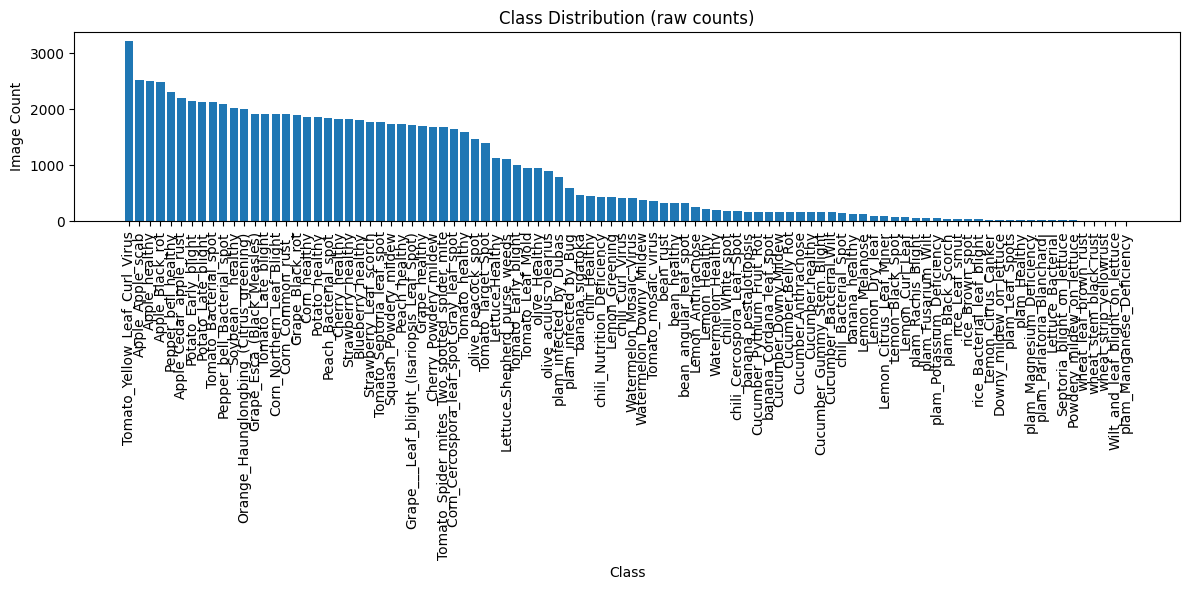

In [9]:
def count_images_per_class(classes):
    rows = []
    for c in tqdm(classes, desc="Counting images per class"):
        n = sum(1 for p in c.iterdir() if is_image(p))
        rows.append({"class": c.name, "count": n})
    df = pd.DataFrame(rows).sort_values("class").reset_index(drop=True)
    return df

df_counts = count_images_per_class(classes)
display(df_counts)
report_table("Class Counts", df_counts, "class_counts.csv", show_rows=len(df_counts))

df_sorted = df_counts.sort_values("count", ascending=False).reset_index(drop=True)
plt.figure(figsize=(12,6))
plt.bar(df_sorted["class"], df_sorted["count"])
plt.xticks(rotation=90)
plt.title("Class Distribution (raw counts)")
plt.xlabel("Class"); plt.ylabel("Image Count")
bar_path = OUTPUT_DIR / "class_distribution.png"
savefig_and_show(bar_path)
report_image("Class Distribution (bar)", bar_path)

ADD PERCENTAGES + PIE

,class,count,percentage
0,Tomato_Yellow_Leaf_Curl_Virus,3208,3.824055
1,Apple_Apple_scab,2520,3.003934
2,Apple_healthy,2510,2.992013
3,Apple_Black_rot,2484,2.961020
4,Pepper_bell_healthy,2300,2.741686
5,Apple_Cedar_apple_rust,2200,2.622482
6,Potato_Early_blight,2149,2.561688
7,Potato_Late_blight,2131,2.540231
8,Tomato_Bacterial_spot,2127,2.535463
9,Pepper_bell_Bacterial_spot,2088,2.488974


/var/folders/n7/8spcbrh50f3dfg_tvt66rsbm0000gn/T/ipykernel_10258/863437329.py:45: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


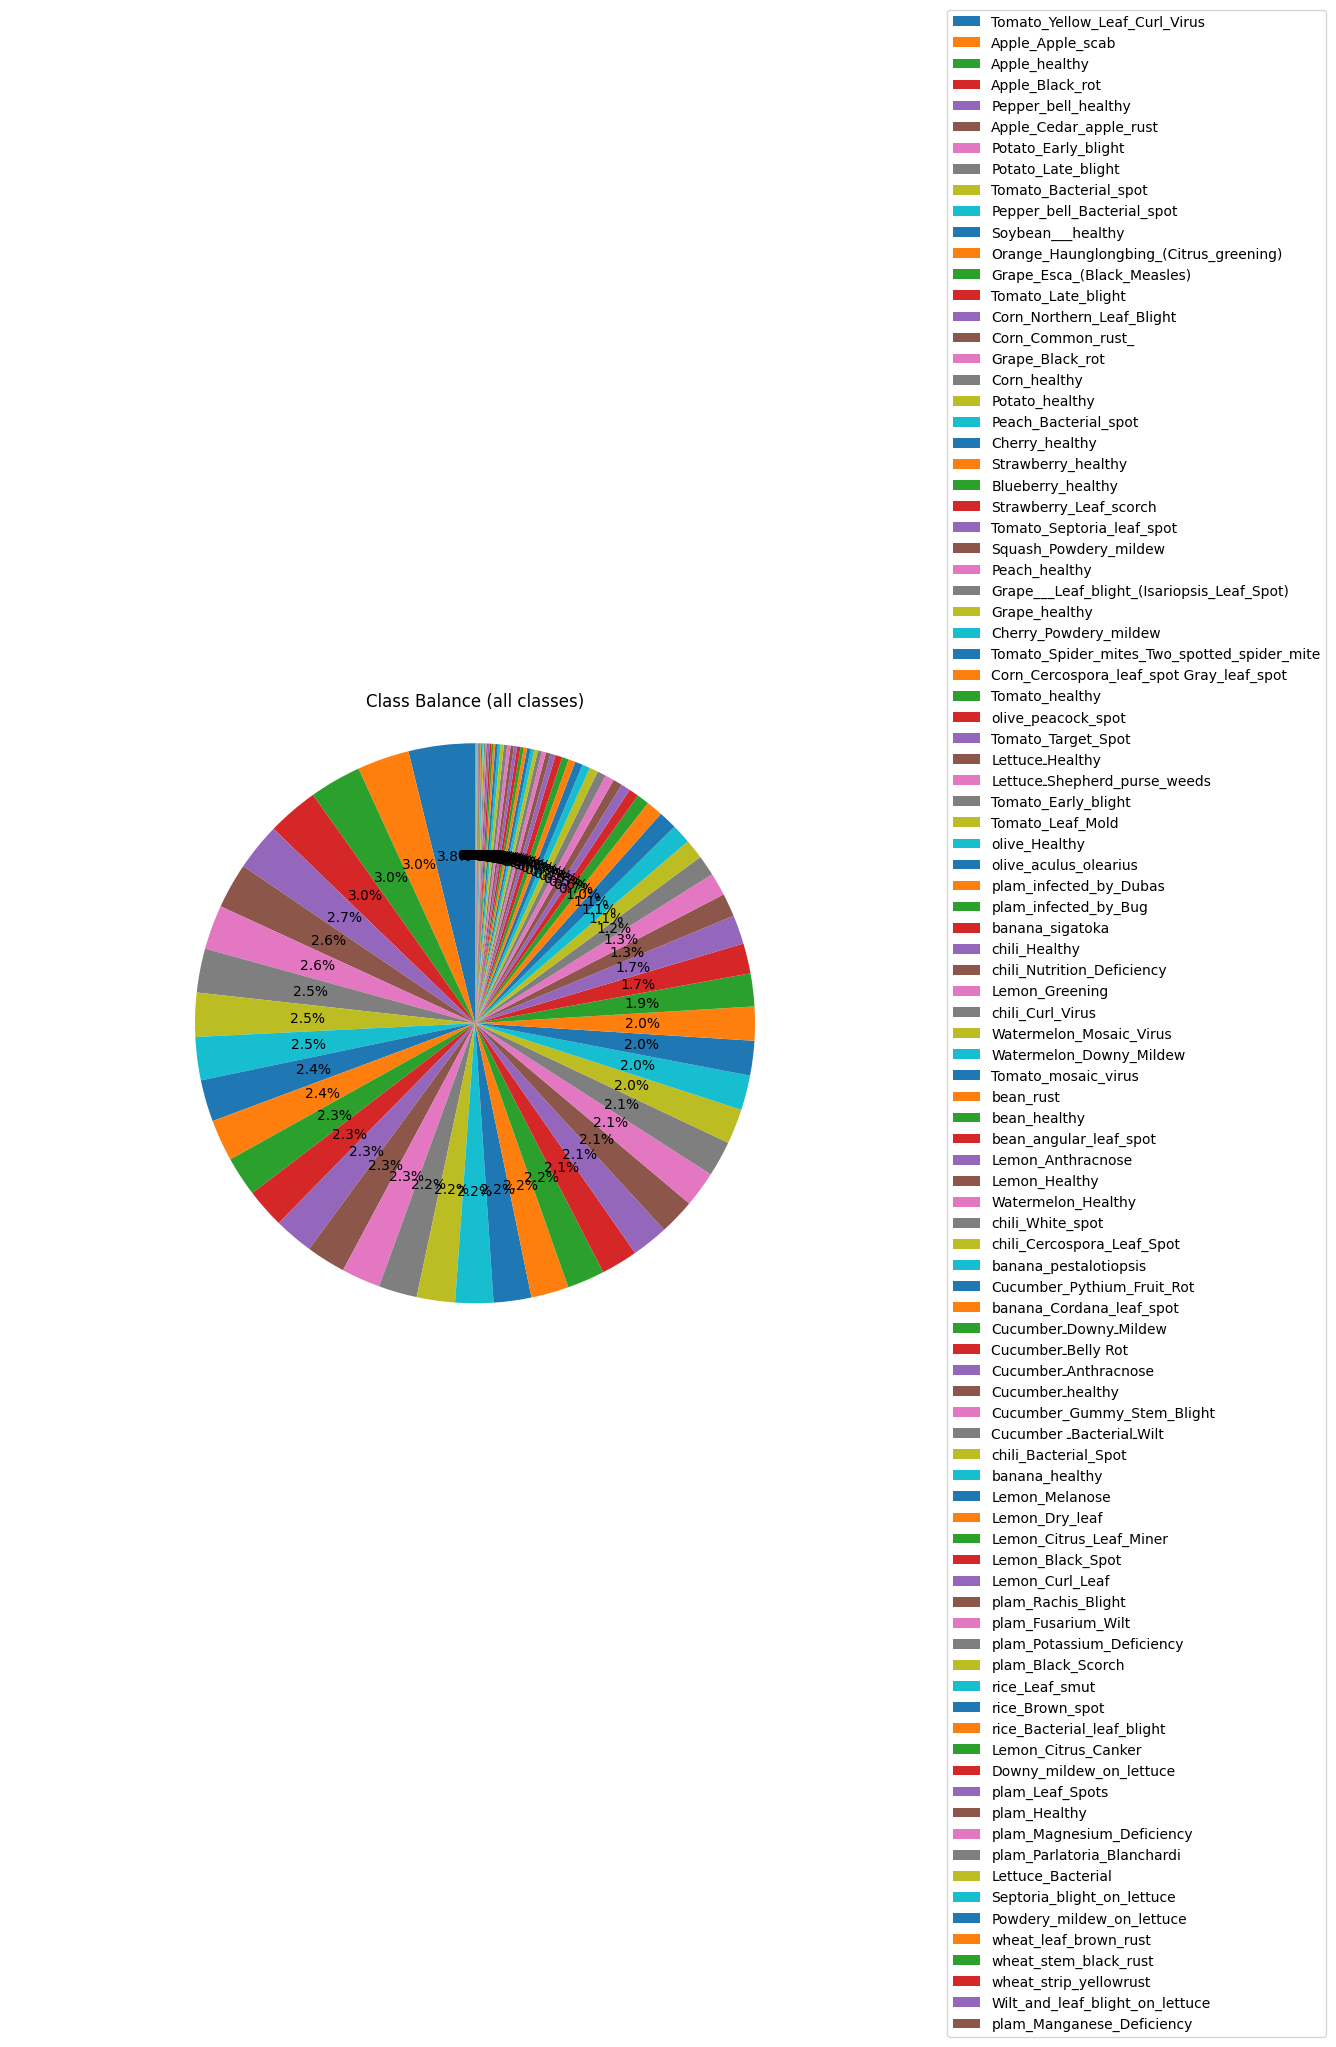

In [10]:
def add_percentages(df_counts: pd.DataFrame):
    total = int(df_counts["count"].sum())
    df2 = df_counts.copy()
    df2["percentage"] = (df2["count"] / total) * 100.0
    df2 = df2.sort_values("count", ascending=False).reset_index(drop=True)
    return df2

df_pct = add_percentages(df_counts)
display(df_pct)
report_table("Class Counts with Percentage", df_pct, "class_counts_with_percentage.csv", show_rows=len(df_pct))

if ENABLE_PIE_CHART:
    plt.figure(figsize=(12,8))
    plt.pie(df_pct["percentage"], autopct="%.1f%%", startangle=90)
    plt.title("Class Balance (all classes)")
    plt.axis('equal')
    plt.legend(df_pct["class"], loc="center left", bbox_to_anchor=(1, 0.5))
    pie_path = OUTPUT_DIR / "class_balance.png"
    savefig_and_show(pie_path)
    report_image("Class Balance (pie)", pie_path)

CORRUPTED IMAGES CHECK

Scanning corrupted images: 100%|██████████| 96/96 [01:51<00:00,  1.16s/it]


,class,corrupted
0,Apple_Apple_scab,0
1,Apple_Black_rot,0
70,chili_Bacterial_Spot,0
69,bean_rust,0
68,bean_healthy,0
67,bean_angular_leaf_spot,0
66,banana_sigatoka,0
65,banana_pestalotiopsis,0
64,banana_healthy,0
63,banana_Cordana_leaf_spot,0


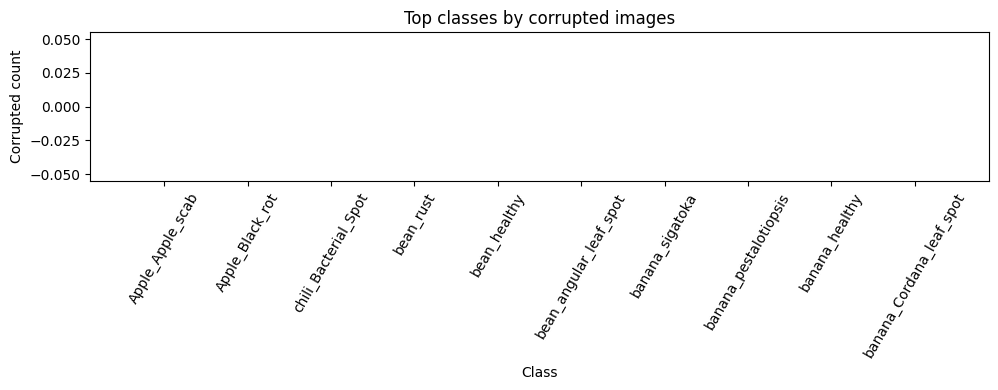

In [11]:
def find_corrupted_images(classes):
    bad_files, per_class = [], []
    for c in tqdm(classes, desc="Scanning corrupted images"):
        bad_in_class = 0
        for p in c.iterdir():
            if not is_image(p):
                continue
            im = safe_imread(p)
            if im is None:
                bad_files.append(str(p))
                bad_in_class += 1
        per_class.append({"class": c.name, "corrupted": bad_in_class})
    df_bad = pd.DataFrame(per_class).sort_values("corrupted", ascending=False)
    if bad_files:
        with open(OUTPUT_DIR / "corrupted_images.json", "w", encoding="utf-8") as f:
            json.dump(bad_files, f, ensure_ascii=False, indent=2)
    return bad_files, df_bad

bad_files, bad_df = find_corrupted_images(classes)
display(bad_df)
report_table("Corrupted Images per Class", bad_df, "corrupted_counts_per_class.csv", show_rows=len(bad_df))
report_section("Corrupted Summary", f"Total corrupted files: **{len(bad_files)}**" + (", saved to `corrupted_images.json`" if bad_files else ""))

# optional top-10 bar
top_bad = bad_df.head(10)
plt.figure(figsize=(10,4))
plt.bar(top_bad["class"], top_bad["corrupted"])
plt.xticks(rotation=60)
plt.title("Top classes by corrupted images")
plt.xlabel("Class"); plt.ylabel("Corrupted count")
corr_path = OUTPUT_DIR / "corrupted_top10.png"
savefig_and_show(corr_path)
report_image("Top classes by corrupted images", corr_path)

RANDOM SAMPLE GRID

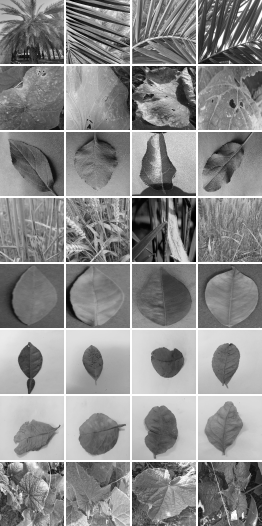

In [12]:
def save_sample_grid(classes, max_classes=8, samples_per_class=4, tile_size=(64,64)):
    try:
        chosen = random.sample(classes, k=min(max_classes, len(classes)))
    except ValueError:
        chosen = classes
    tiles = []
    for c in chosen:
        imgs = [p for p in c.iterdir() if is_image(p)]
        random.shuffle(imgs)
        imgs = imgs[:samples_per_class]
        for p in imgs:
            im = safe_imread(p, flags=cv2.IMREAD_GRAYSCALE)
            if im is None: 
                continue
            im = cv2.resize(im, tile_size, interpolation=cv2.INTER_AREA)
            tiles.append(im)
    if not tiles:
        return None
    rows, cols = max_classes, samples_per_class
    rows = min(rows, int(np.ceil(len(tiles)/max(1, cols))))
    h, w = tile_size
    pad = 2
    grid = np.full((rows*(h+pad)-pad, cols*(w+pad)-pad), 255, dtype=np.uint8)
    idx = 0
    for r in range(rows):
        for c in range(cols):
            if idx >= len(tiles): break
            rh, ch = r*(h+pad), c*(w+pad)
            grid[rh:rh+h, ch:ch+w] = tiles[idx]
            idx += 1
    out_path = OUTPUT_DIR / "sample_grid.png"
    cv2.imwrite(str(out_path), grid)
    return out_path

if ENABLE_SAMPLE_GRID:
    grid_path = save_sample_grid(classes, max_classes=8, samples_per_class=4, tile_size=(64,64))
    if grid_path:
        show_png_file(grid_path)
        report_image("Sample Grid", grid_path)

DUPLICATE CHECK

In [13]:
def find_duplicates_by_hash(classes, limit_per_class=None):
    dup_report, total_dups = {}, 0
    for c in tqdm(classes, desc="Duplicate scan (md5)"):
        files = [p for p in c.iterdir() if is_image(p)]
        if limit_per_class is not None:
            files = files[:limit_per_class]
        seen, dups = {}, []
        for p in files:
            try:
                h = md5_of_file(p)
            except Exception:
                continue
            if h in seen:
                dups.append(str(p))
            else:
                seen[h] = str(p)
        if dups:
            dup_report[c.name] = {"duplicates": dups, "kept_example": next(iter(seen.values()))}
            total_dups += len(dups)
    if dup_report:
        with open(OUTPUT_DIR / "duplicates_by_class.json", "w", encoding="utf-8") as f:
            json.dump(dup_report, f, ensure_ascii=False, indent=2)
    return dup_report, total_dups

dups, total_dups = ({}, 0)
if ENABLE_DUP_CHECK:
    dups, total_dups = find_duplicates_by_hash(classes, limit_per_class=DUP_SCAN_LIMIT_PER_CLASS)

report_section("Duplicates Summary", f"Total duplicate files (scanned): **{total_dups}**" + (" (see `duplicates_by_class.json`)" if total_dups else ""))

if dups:
    df_dups_per_class = (
        pd.DataFrame([{"class": k, "duplicates": len(v["duplicates"])} for k,v in dups.items()])
        .sort_values("duplicates", ascending=False)
        .reset_index(drop=True)
    )
    display(df_dups_per_class)
    report_table("Duplicates per Class", df_dups_per_class, "duplicates_per_class.csv", show_rows=len(df_dups_per_class))
else:
    print("No duplicates detected in the scanned set.")

Duplicate scan (md5): 100%|██████████| 96/96 [00:27<00:00,  3.53it/s]


,class,duplicates
0,olive_Healthy,59
1,plam_infected_by_Bug,59
2,banana_healthy,38
3,olive_aculus_olearius,14
4,Apple_healthy,10
5,Cucumber_Pythium_Fruit_Rot,9
6,Tomato_Late_blight,8
7,Tomato_healthy,6
8,LettuceـShepherd_purse_weeds,4
9,chili_Bacterial_Spot,4


MAIN

In [ ]:
# corrupted count
corr_json = OUTPUT_DIR / "corrupted_images.json"
corrupted_count = 0
if corr_json.exists():
    with open(corr_json, encoding="utf-8") as f:
        corrupted_count = len(json.load(f))

summary_md = (
    f"- Classes: **{len(classes)}**\n"
    f"- Total images: **{int(df_counts['count'].sum())}**\n"
    f"- Corrupted files: **{corrupted_count}**\n"
    f"- Duplicates (scanned): **{total_dups}**\n"
    f"- Outputs folder: `{OUTPUT_DIR.name}`\n"
    f"- Report file: `{REPORT_PATH.name}`\n"
)

display(Markdown("## Final Summary\n\n" + summary_md))
report_section("Final Summary", summary_md)

## Final Summary

- Classes: **96**
- Total images: **83890**
- Corrupted files: **0**
- Duplicates (scanned): **222**
- Outputs folder: `EDA_outputs`
- Report file: `eda_report.md`
